# 🧪 Improved Machine Learning Pipeline for Subtype Classification
This notebook demonstrates an improved workflow for classifying subtypes in patient data. It includes preprocessing with `ColumnTransformer`, reusable pipelines for multiple models, and evaluation using cross-validation and feature importance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import pickle

In [2]:
# Load the data
df = pd.read_csv('./datasets/filtered_data.csv')
df = df.drop(columns=['patient_id'])
df.head()

,gender,age,race,ESR1,PGR,ERBB2,subtype
0,female,60,white,Positive,Positive,Negative,Luminal A
1,female,50,white,Negative,Negative,Positive,HER2-enriched
2,female,71,white,Positive,Positive,Negative,Luminal A
3,female,76,not reported,Positive,Positive,Negative,Luminal A
4,female,74,white,Positive,Positive,Positive,Luminal B


In [3]:
# Define target and features
X = df.drop(columns=['subtype'])
y = df['subtype']

# Split data BEFORE encoding (prevents data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
# Define categorical and numerical columns
categorical_features = ['gender', 'race', 'ESR1', 'PGR', 'ERBB2']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Column transformer
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

In [8]:
# Define reusable model pipelines
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

knn_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [9]:
# Train both models
rf_pipeline.fit(X_train, y_train)
knn_pipeline.fit(X_train, y_train)

# Predict and evaluate
rf_preds = rf_pipeline.predict(X_test)
knn_preds = knn_pipeline.predict(X_test)

print("=== Random Forest Report ===")
print(classification_report(y_test, rf_preds))

print("=== KNN Report ===")
print(classification_report(y_test, knn_preds))

=== Random Forest Report ===
                 precision    recall  f1-score   support

  HER2-enriched       1.00      1.00      1.00         8
      Luminal A       1.00      1.00      1.00        92
      Luminal B       1.00      1.00      1.00        27
Triple Negative       1.00      1.00      1.00        30

       accuracy                           1.00       157
      macro avg       1.00      1.00      1.00       157
   weighted avg       1.00      1.00      1.00       157

=== KNN Report ===
                 precision    recall  f1-score   support

  HER2-enriched       1.00      1.00      1.00         8
      Luminal A       1.00      1.00      1.00        92
      Luminal B       1.00      1.00      1.00        27
Triple Negative       1.00      1.00      1.00        30

       accuracy                           1.00       157
      macro avg       1.00      1.00      1.00       157
   weighted avg       1.00      1.00      1.00       157



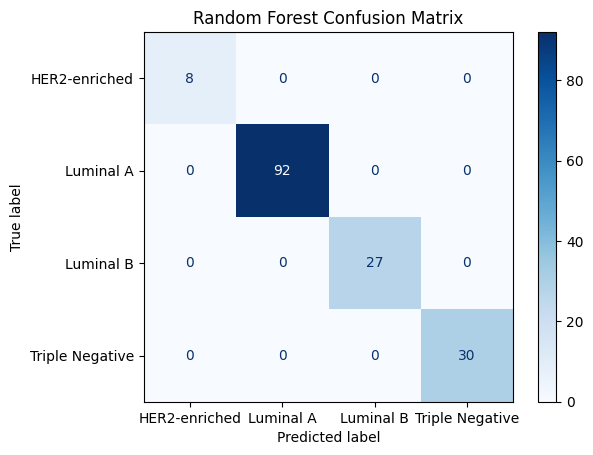

In [10]:
ConfusionMatrixDisplay.from_estimator(rf_pipeline, X_test, y_test, cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_12756\2339204447.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='subtype', palette='viridis')


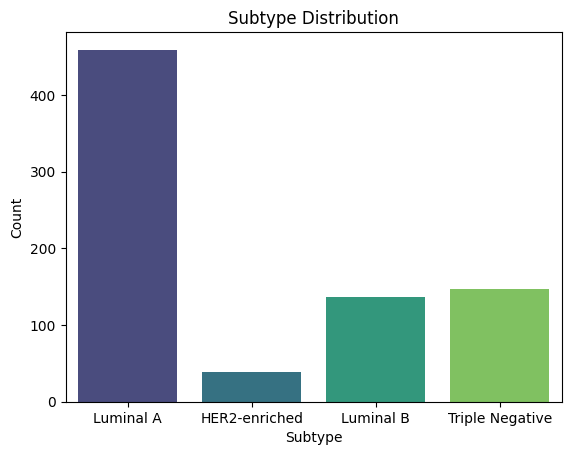

In [14]:
# Show the Subtype distribution in the dataset
sns.countplot(data=df, x='subtype', palette='viridis')
plt.title("Subtype Distribution")
plt.xlabel("Subtype")
plt.ylabel("Count")
plt.show()

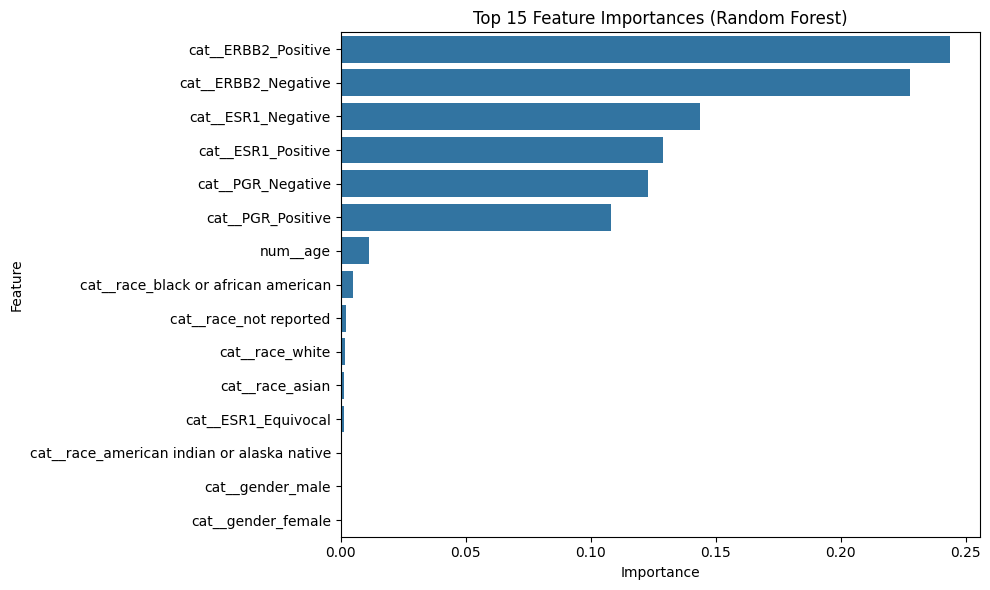

In [11]:
# Feature importance (only for RandomForest)
rf_model = rf_pipeline.named_steps['classifier']
encoded_columns = rf_pipeline.named_steps['preprocessing'].get_feature_names_out()

importances = rf_model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': encoded_columns, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

In [13]:
# Save trained model for deployment (optional)
with open('./models/final_rf_model.pkl', 'wb') as f:
    pickle.dump(rf_pipeline, f)